In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

In [2]:
def generate_dataset(params):
    """
    Generate random multivariate normal dataset
    """
    mu_norm = params['mu_norm']
    sigma = params['sigma']
    n = params['n']
    p = params['p']
    d = params['d']

    # Generate a random point on the unit sphere
    mu = np.random.normal(0, 1, d)
    mu = mu / np.linalg.norm(mu)
    mu = mu * mu_norm

    cov = np.eye(d) * sigma
    n_pos, n_maj, n_min = np.random.multinomial(n, (1/2, p/2, (1-p)/2))
    X_pos = np.random.multivariate_normal(mu, cov, n_pos)
    X_maj = np.random.multivariate_normal(-mu, cov, n_maj)
    X_min = np.random.multivariate_normal(3*mu, cov, n_min)
    X_neg = np.concatenate((X_maj, X_min))

    return X_pos, X_neg


def phi(x):
    return norm.cdf(x)


def lda_err_bound(mu_norm, sigma, p):
    s1 = phi(-(2*p - 1) * mu_norm / sigma)
    s2 = p * phi(-(3 - 2*p) * mu_norm / sigma)
    s3 = (1 - p) * phi((2*p + 1) * mu_norm / sigma)
    bound = (s1 + s2 + s3) / 2

    return bound


def mda_err_bound(mu_norm, sigma, p):
    s1 = phi(-mu_norm / sigma + sigma * np.log(p) / 2 / mu_norm)
    s2 = phi(-mu_norm / sigma + sigma * np.log(1 - p) / 2 / mu_norm)
    s3 = p * phi(-mu_norm / sigma - sigma * np.log(p) / 2 / mu_norm)
    s4 = (1 - p) * phi(-mu_norm / sigma - sigma * np.log(1 - p) / mu_norm)
    bound = (s1 + s2 + s3 + s4) / 2

    return bound


def fit_and_evaluate_lda(X_train, y_train, X_test, y_test):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred_lda = lda.predict(X_test)
    return 1 - accuracy_score(y_test, y_pred_lda)


def mda_predict(X, mu, sigma, p):
    """
    Mixture Discriminant Analysis model
    """
    cov = sigma * np.eye(mu.shape[0])

    f_1 = multivariate_normal.pdf(X, mu, cov)
    f_m1 = multivariate_normal.pdf(X, -mu, cov)
    f_3m = multivariate_normal.pdf(X, 3 * mu, cov)

    preds = []
    for fx_1, fx_m1, fx_3m in zip(f_1, f_m1, f_3m):
        cond1 = 0.5 * fx_1 >= p / 2 * fx_m1
        cond2 = 0.5 * fx_1 >= (1 - p) / 2 * fx_3m
        if cond1 and cond2:
            preds.append(1)
        else:
            preds.append(0)

    return np.array(preds)


def fit_and_evaluate_mda(X_train, y_train, X_test, y_test, params):
    # Estimate mu from the positive class in the training data
    mu = np.mean(X_train[y_train == 1], axis=0)

    y_pred_mda = mda_predict(X_test, mu, params['sigma'], params['p'])
    return 1 - accuracy_score(y_test, y_pred_mda)


def experiment(params, iters):
    """
    Run experiments for a given number of iterations and average the error rates
    """
    lda_error_rates = []
    mda_error_rates = []

    for i in range(iters):
        X_pos, X_neg = generate_dataset(params)
        X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
            X_pos, np.ones(X_pos.shape[0]), test_size=0.3, random_state=i**2 % 1000,
        )
        X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
            X_neg, np.zeros(X_neg.shape[0]), test_size=0.3, random_state=i**2 % 1000,
        )

        X_train = np.concatenate((X_train_pos, X_train_neg))
        y_train = np.concatenate((y_train_pos, y_train_neg))
        X_test = np.concatenate((X_test_pos, X_test_neg))
        y_test = np.concatenate((y_test_pos, y_test_neg))

        lda_error_rates.append(fit_and_evaluate_lda(X_train, y_train, X_test, y_test))
        mda_error_rates.append(fit_and_evaluate_mda(X_train, y_train, X_test, y_test, params))

    return lda_error_rates, mda_error_rates


def experiments_over_parameter(param_name, interval, iters):
    """
    Run experiments over a range of parameter values
    """
    # Default parameters
    params = {
        'mu_norm': 2,
        'sigma': 1,
        'n': 10000,
        'p': 0.9,
        'd': 50,
    }
    
    lda_errors_mean, mda_errors_mean = [], []
    lda_errors_std, mda_errors_std = [], []
    lda_bounds, mda_bounds = [], []

    for param in tqdm(interval):
        params[param_name] = param
        lda_error_rates, mda_error_rates = experiment(params, iters)
        lda_errors_mean.append(np.mean(lda_error_rates))
        lda_errors_std.append(np.std(lda_error_rates) / np.sqrt(iters))
        mda_errors_mean.append(np.mean(mda_error_rates))
        mda_errors_std.append(np.std(mda_error_rates) / np.sqrt(iters))
        lda_bounds.append(lda_err_bound(params['mu_norm'], params['sigma'], params['p']))
        mda_bounds.append(mda_err_bound(params['mu_norm'], params['sigma'], params['p']))

    return lda_errors_mean, mda_errors_mean, lda_errors_std, mda_errors_std, lda_bounds, mda_bounds


def plot_results(
        interval,
        lda_errors_mean, mda_errors_mean,
        lda_errors_std, mda_errors_std,
        lda_bounds, mda_bounds,
        param_name,
    ):
    plt.rcParams.update({'font.size': 12})
    plt.plot(interval, lda_errors_mean, label='LDA Error', color='#1f77b4')
    plt.fill_between(interval,
                     np.array(lda_errors_mean) - 1.96 * np.array(lda_errors_std),
                     np.array(lda_errors_mean) + 1.96 * np.array(lda_errors_std),
                     alpha=0.2, color='#1f77b4')
    plt.plot(interval, mda_errors_mean, label='MDA Error', color='#ff7f0e')
    plt.fill_between(interval,
                     np.array(mda_errors_mean) - 1.96 * np.array(mda_errors_std),
                     np.array(mda_errors_mean) + 1.96 * np.array(mda_errors_std),
                     alpha=0.2, color='#ff7f0e')
    # dashed lines
    plt.plot(interval, lda_bounds, label='LDA Error bound (10)', color='#1f77b4', linestyle='--')
    plt.plot(interval, mda_bounds, label='MDA Error bound (13)', color='#ff7f0e', linestyle='--')
    plt.legend(loc='best')
    plt.savefig(f'figs/lda_mda_{param_name}.png', bbox_inches='tight', dpi=300, transparent=False)
    plt.show()


def plot_lda_results(interval, lda_errors_mean, lda_errors_std, lda_bounds, param_name):
    plt.rcParams.update({'font.size': 12})
    plt.plot(interval, lda_errors_mean, label='LDA Error', color='#1f77b4')
    plt.fill_between(interval,
                     np.array(lda_errors_mean) - 1.96 * np.array(lda_errors_std),
                     np.array(lda_errors_mean) + 1.96 * np.array(lda_errors_std),
                     alpha=0.2, color='#1f77b4')
    plt.plot(interval, lda_bounds, label='LDA Error bound (10)', color='#1f77b4', linestyle='--')
    plt.legend()
    plt.savefig(f'figs/lda_{param_name}.png', bbox_inches='tight', dpi=300, transparent=False)
    plt.show()


def plot_mda_results(interval, mda_errors_mean, mda_errors_std, mda_bounds, param_name):
    plt.rcParams.update({'font.size': 12})
    plt.plot(interval, mda_errors_mean, label='MDA Error', color='#ff7f0e')
    plt.fill_between(interval,
                     np.array(mda_errors_mean) - 1.96 * np.array(mda_errors_std),
                     np.array(mda_errors_mean) + 1.96 * np.array(mda_errors_std),
                     alpha=0.2, color='#ff7f0e')
    plt.plot(interval, mda_bounds, label='MDA Error bound (13)', color='#ff7f0e', linestyle='--')
    plt.legend()
    plt.savefig(f'figs/mda_{param_name}.png', bbox_inches='tight', dpi=300, transparent=False)
    plt.show()

100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


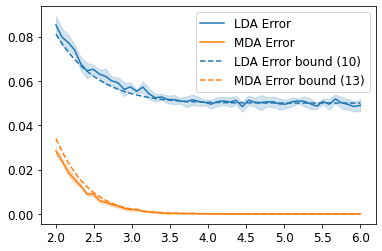

In [36]:
# Vary mu_norm with fixed p and sigma
mu_norms = np.linspace(2, 6, 50)
results = experiments_over_parameter('mu_norm', mu_norms, 10)
plot_results(mu_norms, *results, param_name='mu_norm')

100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


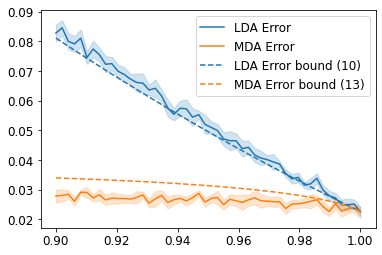

In [37]:
# Vary p with fixed mu_norm and sigma
ps = np.linspace(0.9, 1 - 1e-6, 50)
results = experiments_over_parameter('p', ps, 10)
plot_results(ps, *results, param_name='p')

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


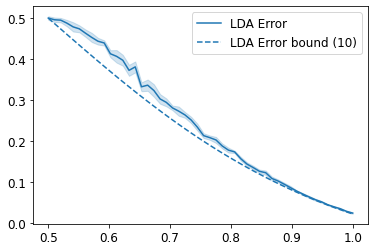

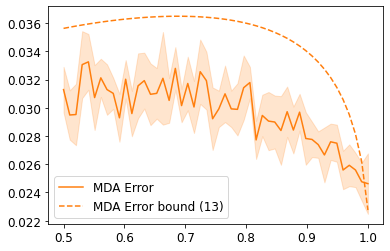

In [38]:
ps = np.linspace(0.5, 1 - 1e-6, 50)
results = experiments_over_parameter('p', ps, 10)
lda_errors_mean, mda_errors_mean, lda_errors_std, mda_errors_std, lda_bounds, mda_bounds = results

plot_lda_results(ps, lda_errors_mean, lda_errors_std, lda_bounds, param_name='p')
plot_mda_results(ps, mda_errors_mean, mda_errors_std, mda_bounds, param_name='p')

In [ ]:
# vary n with fixed mu_norm, p and sigma
ns = np.linspace(100, 10000, 50).astype(int)
results = experiments_over_parameter('n', ns, 10)